In [21]:
import os
import pandas as pd
import numpy as np
from pathlib import Path

# Adjust paths to your setup
DATA_DIR_CSV = Path("/mnt/c/Users/orizarchi/Desktop/Courses/Resting_ECG_Dataset/dat_csv")
DATA_DIR_ANN = Path("/mnt/c/Users/orizarchi/Desktop/Courses/Resting_ECG_Dataset/ann_txt")
OUT_DIR = Path("~/projects/ecg_delineation/data/processed/segments_all").expanduser()
OUT_DIR.mkdir(parents=True, exist_ok=True)

In [22]:
FS = 500  # Hz
SEG_LEFT = 193   # samples left of QRS center
SEG_RIGHT = 318  # samples right of QRS center
SEG_LEN = SEG_LEFT + 1 + SEG_RIGHT  # = 512


In [23]:
# Helper functions

def load_signal(record_id):
    """Load full 12-lead ECG from CSV as numpy array [12, N]."""
    sig_path = DATA_DIR_CSV / f"{record_id}.csv"
    sig = pd.read_csv(sig_path, header=None).values.T
    return sig  # shape [12, length]

def load_annotations(record_id, lead_suffix):
    path = DATA_DIR_ANN / f"{record_id}.{lead_suffix}.txt"
    if not path.exists():
        return None
    anno = pd.read_csv(
        path, skiprows=1, header=None,
        names=["type", "start", "end"]
    )
    anno = anno.dropna()
    anno["type"] = anno["type"].astype(int)
    anno["start"] = anno["start"].astype(int)
    anno["end"] = anno["end"].astype(int)
    return anno

def segment_around_qrs(sig, anno):
    """
    Segment signal around QRS centers.
    Args:
        sig: numpy array [length] for one lead
        anno: DataFrame with columns [type,start,end]
    Returns:
        segments: list of arrays [SEG_LEN]
        labels: list of arrays [SEG_LEN] with values {0=P,1=QRS,2=T,3=bg}
    """
    segments, labels = [], []
    qrs = anno[anno["type"] == 1]  # QRS rows

    for _, row in qrs.iterrows():
        center = (row["start"] + row["end"]) // 2
        start = center - SEG_LEFT
        end = center + SEG_RIGHT

        # pad if segment exceeds boundaries
        pad_left = max(0, -start)
        pad_right = max(0, end - (len(sig) - 1))
        start_clipped = max(0, start)
        end_clipped = min(len(sig) - 1, end)

        seg = np.zeros(SEG_LEN, dtype=np.float32)
        seg[pad_left:SEG_LEN-pad_right] = sig[start_clipped:end_clipped+1]

        # build label vector
        label_vec = np.full(SEG_LEN, 3, dtype=np.int64)  # default = background
        for _, wave in anno.iterrows():
            # mark overlap of wave interval with this segment
            w_start = wave["start"] - start
            w_end = wave["end"] - start
            w_start = max(0, w_start)
            w_end = min(SEG_LEN-1, w_end)
            if w_end >= 0 and w_start < SEG_LEN:
                label_vec[w_start:w_end+1] = wave["type"]

        segments.append(seg)
        labels.append(label_vec)

    return segments, labels

In [28]:
# Process whole dataset and save
import pickle

def process_and_save(record_id, lead_suffix="ii"):
    sig = load_signal(record_id)[1]  # lead II only for now
    anno = load_annotations(record_id, lead_suffix)
    if anno is None:
        return 0
    segments, labels = segment_around_qrs(sig, anno)
    if not segments:
        return 0

    out_file = OUT_DIR / f"{record_id}_{lead_suffix}.npz"
    with open(out_file, "wb") as f:
        pickle.dump({"segments": segments, "labels": labels}, f)
    return len(segments)

# Example: loop over a few records
record_ids = ["SB0198"]
for rid in record_ids:
    n = process_and_save(rid, "ii")
    print(f"{rid}: saved {n} beats")


SB0198: saved 5 beats


SB0198: 5 beats


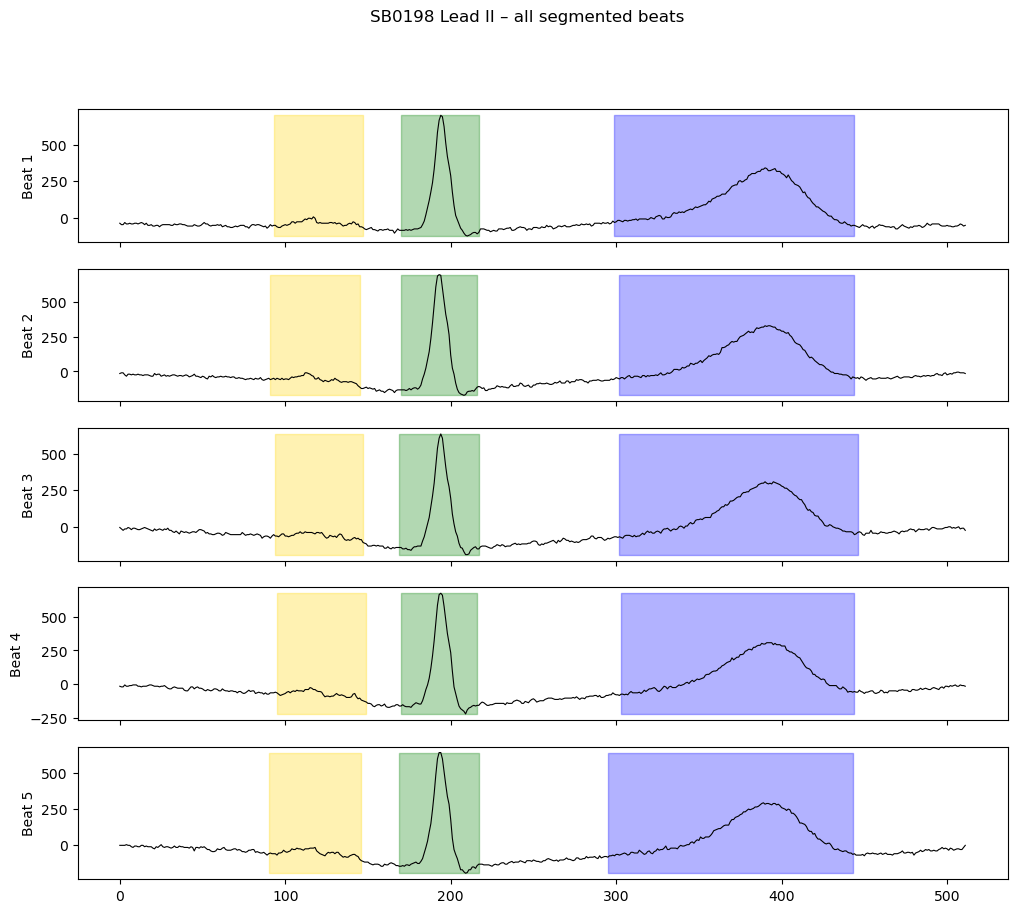

In [29]:
import pickle
import matplotlib.pyplot as plt

def visualize_saved_beats(record_ids, out_dir, lead="II"):
    for rid in record_ids:
        file = Path(out_dir) / f"{rid}_ii.npz"
        if not file.exists():
            print(f"File not found: {file}")
            continue

        with open(file, "rb") as f:
            data = pickle.load(f)

        segments = data["segments"]
        labels = data["labels"]

        print(f"{rid}: {len(segments)} beats")

        # Plot all beats in one figure (stacked)
        fig, axes = plt.subplots(len(segments), 1,
                                 figsize=(12, 2*len(segments)),
                                 sharex=True)
        if len(segments) == 1:
            axes = [axes]

        colors = {0: "gold", 1: "green", 2: "blue", 3: "lightgray"}
        for i, (seg, lab) in enumerate(zip(segments, labels)):
            axes[i].plot(seg, color="black", linewidth=0.8)
            for t, c in colors.items():
                mask = (lab == t)
                if mask.any() and t != 3:  # skip bg in overlay
                    axes[i].fill_between(
                        range(len(seg)), seg.min(), seg.max(),
                        where=mask, color=c, alpha=0.3
                    )
            axes[i].set_ylabel(f"Beat {i+1}")
        plt.suptitle(f"{rid} Lead {lead} – all segmented beats")
        plt.show()

# Example usage
visualize_saved_beats(record_ids, OUT_DIR)
